In [48]:
import numpy as np
import matplotlib.pyplot as plt

from resnet import ResNet
from get_te import get_te

from tqdm.notebook import tqdm

## Generate Lorenz '63 trajectory

In [14]:
def lorenz(x, y, z, s=10, r=28, b=2.667):
    '''
    Given:
       x, y, z: a point of interest in three dimensional space
       s, r, b: parameters defining the lorenz attractor
    Returns:
       x_dot, y_dot, z_dot: values of the lorenz attractor's partial
           derivatives at the point x, y, z
    '''
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return x_dot, y_dot, z_dot

dt = 0.02
num_steps = 6250

# Need one more for the initial values
xs = np.empty(num_steps + 1)
ys = np.empty(num_steps + 1)
zs = np.empty(num_steps + 1)

# Set initial values
xs[0], ys[0], zs[0] = (0., 1., 1.05)

# Step through "time", calculating the partial derivatives at the current point
# and using them to estimate the next point
for i in range(num_steps):
    x_dot, y_dot, z_dot = lorenz(xs[i], ys[i], zs[i])
    xs[i + 1] = xs[i] + (x_dot * dt)
    ys[i + 1] = ys[i] + (y_dot * dt)
    zs[i + 1] = zs[i] + (z_dot * dt)
    
traj = np.vstack((xs[1:],ys[1:],zs[1:]))
time = np.linspace(-100,25,num_steps)


## Sensitivity of $t_e$ to hyperparameters

In [72]:
# Hyperparameter values
rho_vals = np.linspace(0.5,2.5,41)

In [73]:
# warmup
w = 50
trajtest = traj[:,5000+w-1:]

# Train RC for the different hyperparameter values
N_ensemble = 10

resnets = []
preds = []
for i in tqdm(range(len(rho_vals))):
    resnets_ensemble = []
    preds_ensemble = []
    for j in range(N_ensemble):
        resnets_ensemble.append(ResNet(N=300, degree=6, spr=rho_vals[i]))
        resnets_ensemble[j].train(traj[:,:5000])
        resnets_ensemble[j].compute_Wout(traj[:,:5000])
        preds_ensemble.append(resnets_ensemble[j].test(traj[:,5000:], warmup=50))
    resnets.append(resnets_ensemble)
    preds.append(preds_ensemble)

  0%|          | 0/41 [00:00<?, ?it/s]

/home/reykiboy/Documents/phd/criticalearth/workshop2/ReservoirComputingLorenz/resnet.py:53: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.W = nx.adjacency_matrix(reservoir).todense()


In [74]:
# Calculate t_e for different hyperparameter values
tes = []
tes_std = []
for i in range(len(rho_vals)):
    tes_ensemble = []
    for j in range(N_ensemble):
        tes_ensemble.append(get_te(preds[i][j],trajtest,eps=0.4,error_version='normnorm'))
    tes.append(np.mean(np.array(tes_ensemble)))
    tes_std.append(np.std(np.array(tes_ensemble)))

tes_err = tes_std/np.sqrt(N_ensemble)

Error exceeds threshold value 0.4 after 2 time steps --> t_e = 0.040.
Error exceeds threshold value 0.4 after 2 time steps --> t_e = 0.040.
Error exceeds threshold value 0.4 after 2 time steps --> t_e = 0.040.
Error exceeds threshold value 0.4 after 3 time steps --> t_e = 0.060.
Error exceeds threshold value 0.4 after 35 time steps --> t_e = 0.700.
Error exceeds threshold value 0.4 after 2 time steps --> t_e = 0.040.
Error exceeds threshold value 0.4 after 18 time steps --> t_e = 0.360.
Error exceeds threshold value 0.4 after 8 time steps --> t_e = 0.160.
Error exceeds threshold value 0.4 after 3 time steps --> t_e = 0.060.
Error exceeds threshold value 0.4 after 2 time steps --> t_e = 0.040.
Error exceeds threshold value 0.4 after 3 time steps --> t_e = 0.060.
Error exceeds threshold value 0.4 after 5 time steps --> t_e = 0.100.
Error exceeds threshold value 0.4 after 11 time steps --> t_e = 0.220.
Error exceeds threshold value 0.4 after 31 time steps --> t_e = 0.620.
Error exceeds th

[Text(0.5, 0, 'rho'), Text(0, 0.5, 't_e')]

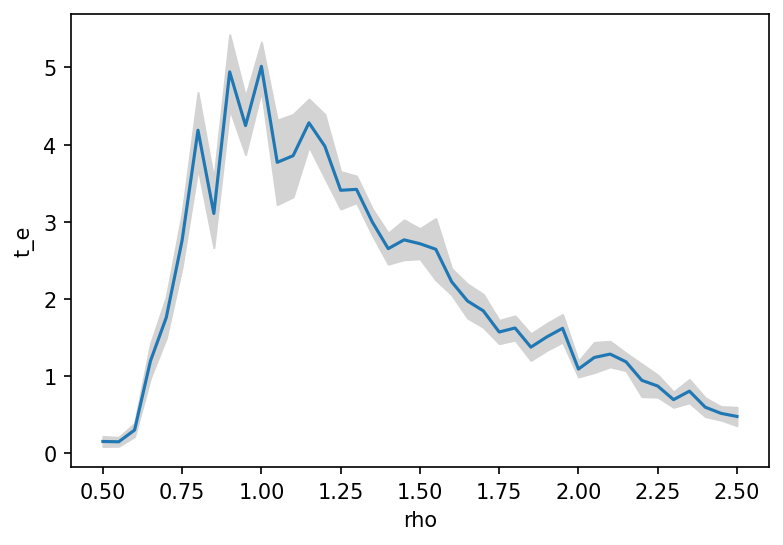

In [75]:
# plot results
fig, ax = plt.subplots(dpi=150)
ax.plot(rho_vals, tes)
ax.fill_between(rho_vals, tes+tes_err, tes-tes_err, color='lightgray')
ax.set(xlabel='rho', ylabel='t_e')